# Bitcoin Reddit Sentiment Analysis


## Project Overview

This notebook performs sentiment analysis on Reddit posts and comments from the `r/Bitcoin` subreddit. It uses a transformer-based NLP model to classify public sentiment as positive, neutral, or negative, and visualizes the distribution of opinions to estimate the overall market sentiment.


Scraping 100 posts from r/Bitcoin...
Successfully scraped 473 text items
Loading sentiment analysis model...


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Analyzing sentiment...

SENTIMENT ANALYSIS RESULTS
Total texts analyzed: 473
Overall Market Sentiment: Bearish
Positive: 20.7%
Negative: 22.0%
Neutral: 57.3%


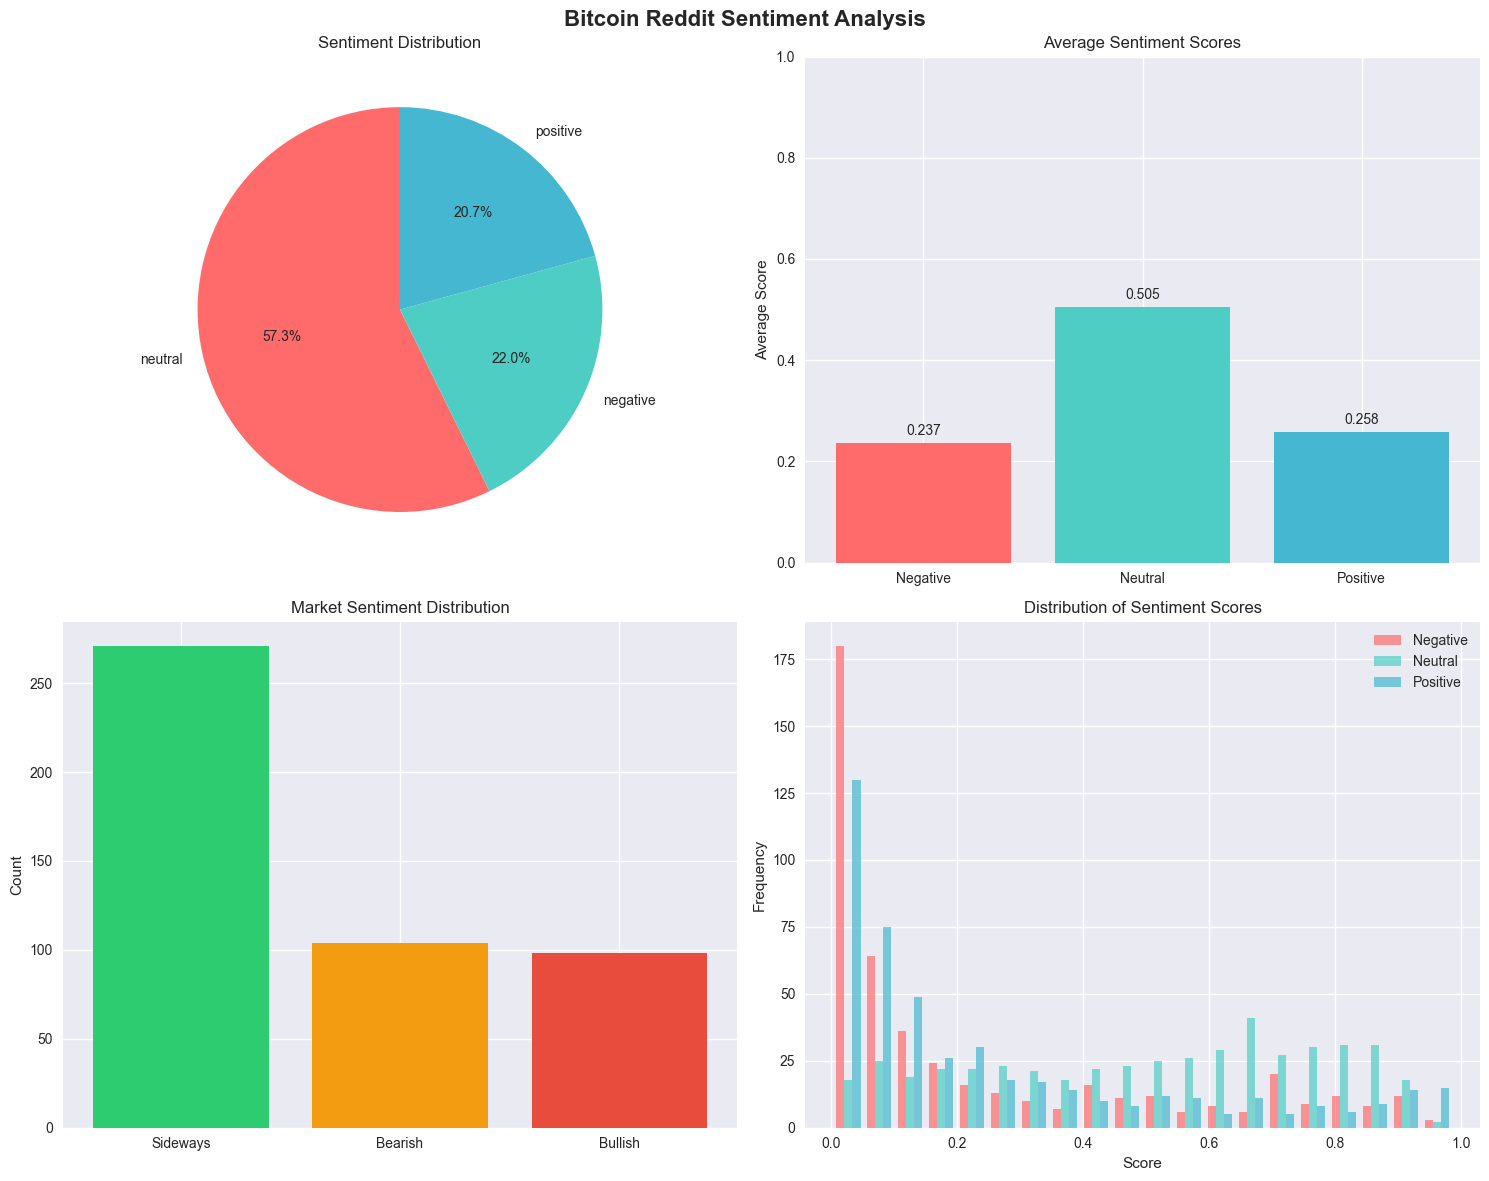

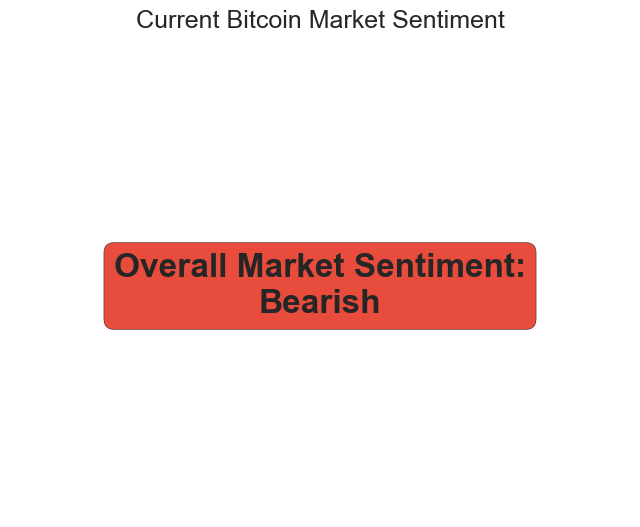


Sample sentiment results:
                                                Text Sentiment
0               Bitcoin Newcomers FAQ - Please read!   neutral
1  Please feel free to make [constructive edits](...   neutral
2                    Daily Discussion, July 10, 2025   neutral
3  **Historical Bitcoin prices for today, July 10...   neutral
4  All these posts about 'I have a gazzilion doll...   neutral
5  [48 days since the last all-time-high](https:/...  positive
6  Enjoy the USD high, but with the dollar crashi...  positive
7                            This train doesn't stop  negative
8                                               Bruh   neutral
9             Vietnamese Dong will getcha every time   neutral


In [ ]:
import os
import pandas as pd
import praw
import numpy as np
from datetime import datetime
import pytz
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Reddit API setup
user_agent = "RedditSentimentAnalyzer/1.0 by u/python_engineer"
reddit = praw.Reddit(
    client_id="",
    client_secret="",
    user_agent=""
)

# Define IST timezone
ist = pytz.timezone('Asia/Kolkata')

def scrape_reddit_data(subreddit_name='Bitcoin', limit=100):
    """
    Scrape Reddit posts and comments from specified subreddit
    """
    texts = []
    
    try:
        print(f"Scraping {limit} posts from r/{subreddit_name}...")
        
        for submission in reddit.subreddit(subreddit_name).hot(limit=limit):
            # Add the post title
            texts.append(submission.title)
            
            # Load comments and add top comments
            submission.comments.replace_more(limit=0)
            for top_comment in submission.comments[:5]:
                if hasattr(top_comment, 'body') and len(top_comment.body.strip()) > 0:
                    texts.append(top_comment.body[:300])  # Limit long comments
        
        print(f"Successfully scraped {len(texts)} text items")
        return texts
        
    except Exception as e:
        print(f"Error scraping Reddit data: {e}")
        return []

def analyze_sentiment(texts):
    """
    Perform sentiment analysis on the scraped texts
    """
    try:
        from transformers import AutoTokenizer, AutoModelForSequenceClassification
        from scipy.special import softmax
        
        print("Loading sentiment analysis model...")
        MODEL = "cardiffnlp/twitter-roberta-base-sentiment-latest"
        tokenizer = AutoTokenizer.from_pretrained(MODEL)
        # model = AutoModelForSequenceClassification.from_pretrained(MODEL)
        model = AutoModelForSequenceClassification.from_pretrained(MODEL, trust_remote_code=True, use_safetensors=True)

        
        def get_sentiment(text):
            if not text or text.strip() == '':
                return 'neutral', [0.33, 0.33, 0.34]
            
            # Clean and truncate text
            text = str(text).strip()[:512]  # Limit to 512 characters
            
            inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
            outputs = model(**inputs)
            scores = softmax(outputs.logits.detach().numpy()[0])
            sentiment_labels = ["negative", "neutral", "positive"]
            
            return sentiment_labels[scores.argmax()], scores
        
        print("Analyzing sentiment...")
        results = []
        for text in texts:
            sentiment, scores = get_sentiment(text)
            results.append({
                'Text': text[:100] + '...' if len(text) > 100 else text,
                'Sentiment': sentiment,
                'Negative_Score': scores[0],
                'Neutral_Score': scores[1],
                'Positive_Score': scores[2]
            })
        
        return pd.DataFrame(results)
        
    except Exception as e:
        print(f"Error in sentiment analysis: {e}")
        return pd.DataFrame()

def calculate_overall_sentiment(df):
    """
    Calculate overall sentiment based on frequency and scores
    """
    if df.empty:
        return "No data available"
    
    # Count sentiment frequencies
    sentiment_counts = df['Sentiment'].value_counts()
    
    # Calculate weighted sentiment scores
    total_negative = df['Negative_Score'].sum()
    total_neutral = df['Neutral_Score'].sum()
    total_positive = df['Positive_Score'].sum()
    
    # Determine overall sentiment
    if sentiment_counts.get('positive', 0) > sentiment_counts.get('negative', 0):
        overall_sentiment = "Bullish"
    elif sentiment_counts.get('negative', 0) > sentiment_counts.get('positive', 0):
        overall_sentiment = "Bearish"
    else:
        overall_sentiment = "Neutral/Sideways"
    
    return {
        'Overall_Sentiment': overall_sentiment,
        'Sentiment_Counts': sentiment_counts.to_dict(),
        'Positive_Percentage': (sentiment_counts.get('positive', 0) / len(df)) * 100,
        'Negative_Percentage': (sentiment_counts.get('negative', 0) / len(df)) * 100,
        'Neutral_Percentage': (sentiment_counts.get('neutral', 0) / len(df)) * 100,
        'Avg_Positive_Score': total_positive / len(df),
        'Avg_Negative_Score': total_negative / len(df),
        'Avg_Neutral_Score': total_neutral / len(df)
    }

def create_visualizations(df, overall_stats):
    """
    Create visualizations for sentiment analysis
    """
    if df.empty:
        print("No data to visualize")
        return
    
    # Set up the plotting style
    plt.style.use('seaborn-v0_8')
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Bitcoin Reddit Sentiment Analysis', fontsize=16, fontweight='bold')
    
    # 1. Sentiment Distribution Pie Chart
    sentiment_counts = df['Sentiment'].value_counts()
    colors = ['#ff6b6b', '#4ecdc4', '#45b7d1']
    axes[0, 0].pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%', 
                   colors=colors, startangle=90)
    axes[0, 0].set_title('Sentiment Distribution')
    
    # 2. Sentiment Scores Bar Chart
    avg_scores = [overall_stats['Avg_Negative_Score'], 
                  overall_stats['Avg_Neutral_Score'], 
                  overall_stats['Avg_Positive_Score']]
    sentiment_labels = ['Negative', 'Neutral', 'Positive']
    bars = axes[0, 1].bar(sentiment_labels, avg_scores, color=colors)
    axes[0, 1].set_title('Average Sentiment Scores')
    axes[0, 1].set_ylabel('Average Score')
    axes[0, 1].set_ylim(0, 1)
    
    # Add value labels on bars
    for bar, score in zip(bars, avg_scores):
        height = bar.get_height()
        axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                       f'{score:.3f}', ha='center', va='bottom')
    
    # 3. Market Sentiment Mapping
    market_mapping = {'positive': 'Bullish', 'neutral': 'Sideways', 'negative': 'Bearish'}
    market_sentiment = df['Sentiment'].map(market_mapping).value_counts()
    axes[1, 0].bar(market_sentiment.index, market_sentiment.values, 
                   color=['#2ecc71', '#f39c12', '#e74c3c'])
    axes[1, 0].set_title('Market Sentiment Distribution')
    axes[1, 0].set_ylabel('Count')
    
    # 4. Sentiment Score Distribution
    axes[1, 1].hist([df['Negative_Score'], df['Neutral_Score'], df['Positive_Score']], 
                    bins=20, alpha=0.7, label=['Negative', 'Neutral', 'Positive'], 
                    color=colors)
    axes[1, 1].set_title('Distribution of Sentiment Scores')
    axes[1, 1].set_xlabel('Score')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Additional visualization: Overall Market Sentiment
    plt.figure(figsize=(8, 6))
    overall_sentiment = overall_stats['Overall_Sentiment']
    sentiment_color = {'Bullish': '#2ecc71', 'Bearish': '#e74c3c', 'Neutral/Sideways': '#f39c12'}
    
    plt.text(0.5, 0.5, f"Overall Market Sentiment:\n{overall_sentiment}", 
             fontsize=24, fontweight='bold', ha='center', va='center',
             bbox=dict(boxstyle="round,pad=0.3", facecolor=sentiment_color.get(overall_sentiment, '#95a5a6')))
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.axis('off')
    plt.title('Current Bitcoin Market Sentiment', fontsize=18, pad=20)
    plt.show()

def main():
    """
    Main function to run the sentiment analysis
    """
    # Scrape Reddit data
    texts = scrape_reddit_data('Bitcoin', limit=100)
    
    if not texts:
        print("No data scraped. Please check your Reddit API credentials.")
        return
    
    # Perform sentiment analysis
    df = analyze_sentiment(texts)
    
    if df.empty:
        print("Sentiment analysis failed.")
        return
    
    # Calculate overall sentiment
    overall_stats = calculate_overall_sentiment(df)
    
    # Display results
    print("\n" + "="*50)
    print("SENTIMENT ANALYSIS RESULTS")
    print("="*50)
    print(f"Total texts analyzed: {len(df)}")
    print(f"Overall Market Sentiment: {overall_stats['Overall_Sentiment']}")
    print(f"Positive: {overall_stats['Positive_Percentage']:.1f}%")
    print(f"Negative: {overall_stats['Negative_Percentage']:.1f}%")
    print(f"Neutral: {overall_stats['Neutral_Percentage']:.1f}%")
    print("="*50)
    
    # Create visualizations
    create_visualizations(df, overall_stats)
    
    # Display sample results
    print("\nSample sentiment results:")
    print(df[['Text', 'Sentiment']].head(10))
    
    return df, overall_stats

# Run the analysis
if __name__ == "__main__":
    # Replace with your actual Reddit API credentials
    reddit = praw.Reddit(
        client_id="",
        client_secret="",
        user_agent=""
    )
    
    df, stats = main()

---

In [3]:
df.head(20)  # Display the first few rows of the DataFrame

,Text,Sentiment,Negative_Score,Neutral_Score,Positive_Score
0,Bitcoin Newcomers FAQ - Please read!,neutral,0.006007,0.688640,0.305353
1,Please feel free to make [constructive edits](...,neutral,0.011838,0.706556,0.281606
2,"Daily Discussion, July 10, 2025",neutral,0.007752,0.920201,0.072047
3,"**Historical Bitcoin prices for today, July 10...",neutral,0.034386,0.892909,0.072706
4,All these posts about 'I have a gazzilion doll...,neutral,0.226438,0.656269,0.117293
5,[48 days since the last all-time-high](https:/...,positive,0.013608,0.409515,0.576876
6,"Enjoy the USD high, but with the dollar crashi...",positive,0.068363,0.342160,0.589477
7,This train doesn't stop,negative,0.692036,0.264894,0.043069
8,Bruh,neutral,0.172856,0.553004,0.274140
9,Vietnamese Dong will getcha every time,neutral,0.059930,0.497871,0.442199


---

## Conclusion

This notebook demonstrates how Reddit sentiment can be used to gauge public opinion on Bitcoin. The results can be integrated into crypto trading models or used for market research.

Future improvements may include:
- Historical trend tracking
- Weighting comments and posts differently
- Multi-subreddit analysis
